# maPCA walkthrough



## Import libraries

In [99]:
from mapca import mapca, utils
import numpy as np
from nilearn import datasets, input_data, masking, image, plotting
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi, plot_epi, show
import nibabel as nib
from nilearn._utils import check_niimg_3d, check_niimg_4d
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Load 4D data, reshape into space x time and normalize

In [104]:
# Download data
dataset = datasets.fetch_development_fmri(n_subjects=1)

# Generate masker
brain_masker = input_data.NiftiMasker(
    detrend=True, mask_strategy='epi',
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

# Get 4D data
img = check_niimg_4d(dataset.func[0])
mask = check_niimg_3d(brain_masker.fit(dataset.func[0]).mask_img_)
data = img.get_fdata()
mask = mask.get_fdata()

# Get shape and reshape
[n_x, n_y, n_z, n_timepoints] = data.shape
data_nib_V = np.reshape(data, (n_x * n_y * n_z, n_timepoints), order="F")
mask_vec = np.reshape(mask, n_x * n_y * n_z, order="F")
X = data_nib_V[mask_vec == 1, :]

n_samples = np.sum(mask_vec)

# Normalize time-series
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X.T).T

## Step 1: Perform SVD on original data

In [41]:
# V = eigenvectors
V, eigenvalues = utils._icatb_svd(X, n_timepoints)

# Reordering of values from highest to lowest
eigenvalues = eigenvalues[::-1]
dataN = np.dot(X, V[:, ::-1])

## Step 2: Apply kurtosis threshold of Gaussianity to SVD data to get first estimate of subsampling depth

In [43]:
def apply_kurtosis(dataN, eigenvalues):
    # Using 12 gaussian components from middle, top and bottom gaussian
    # components to determine the subsampling depth.
    # Final subsampling depth is determined using median
    kurt = kurtosis(dataN, axis=0, fisher=True)
    kurt[kurt < 0] = 0
    kurt = np.expand_dims(kurt, 1)

    kurt[eigenvalues > np.mean(eigenvalues)] = 1000
    idx_gauss = np.where(
        ((kurt[:, 0] < 0.3) & (kurt[:, 0] > 0) & (eigenvalues > np.finfo(float).eps)) == 1
    )[
        0
    ]
    idx = np.array(idx_gauss[:]).T
    dfs = np.sum(eigenvalues > np.finfo(float).eps)  # degrees of freedom
    minTp = 12

    if len(idx) >= minTp:
        middle = int(np.round(len(idx) / 2))
        idx = np.hstack([idx[0:4], idx[middle - 1 : middle + 3], idx[-4:]])
    else:
        minTp = np.min([minTp, dfs])
        idx = np.arange(dfs - minTp, dfs)

    idx = np.unique(idx)
    
    return idx

In [44]:
idx = apply_kurtosis(dataN, eigenvalues)

## Step 3: Calculate the subsampling depth by increasing its value until the entropy rate of the subsampled sequence reaches the upper bound

In [53]:
def estimate_subsampling_depth(dataN, mask_ND):
    # Estimate the subsampling depth for effectively i.i.d. samples
    sub_depth = len(idx)
    sub_iid_sp = np.zeros((sub_depth,))
    for i in range(sub_depth):
        x_single = np.zeros(n_x * n_y * n_z)
        x_single[mask_vec == 1] = dataN[:, idx[i]]
        x_single = np.reshape(x_single, (n_x, n_y, n_z), order="F")
        sub_iid_sp[i] = utils._est_indp_sp(x_single)[0] + 1
        if i > 6:
            tmp_sub_sp = sub_iid_sp[0:i]
            tmp_sub_median = np.round(np.median(tmp_sub_sp))
            if np.sum(tmp_sub_sp == tmp_sub_median) > 6:
                sub_iid_sp = tmp_sub_sp
                break
        dim_n = x_single.ndim

    sub_iid_sp_median = int(np.round(np.median(sub_iid_sp)))
    if np.floor(np.power(n_samples / n_timepoints, 1 / dim_n)) < sub_iid_sp_median:
        sub_iid_sp_median = int(np.floor(np.power(n_samples / n_timepoints, 1 / dim_n)))
        
    N = np.round(n_samples / np.power(sub_iid_sp_median, dim_n))
        
    return sub_iid_sp_median, N

In [54]:
mask_ND = np.reshape(mask_vec, (n_x, n_y, n_z), order="F")
sub_iid_sp_median, N = estimate_subsampling_depth(dataN, mask_ND )

print("Effective number of i.i.d. samples %d" % N)

Effective number of i.i.d. samples 3032


## Step 4: Generate subsampled data

In [57]:
def generate_subsampled_data(mask_ND, sub_iid_sp_median, n_timepoints, mask_shape):
    n_x, n_y, n_z = mask_shape
    mask_s = utils._subsampling(mask_ND, sub_iid_sp_median)
    mask_s_1d = np.reshape(mask_s, np.prod(mask_s.shape), order="F")
    dat = np.zeros((int(np.sum(mask_s_1d)), n_timepoints))
    for i_vol in range(n_timepoints):
        x_single = np.zeros(n_x * n_y * n_z)
        x_single[mask_vec == 1] = X[:, i_vol]
        x_single = np.reshape(x_single, (n_x, n_y, n_z), order="F")
        dat0 = utils._subsampling(x_single, sub_iid_sp_median)
        dat0 = np.reshape(dat0, np.prod(dat0.shape), order="F")
        dat[:, i_vol] = dat0[mask_s_1d == 1]
        
    return dat

In [58]:
dat = generate_subsampled_data(mask_ND, sub_iid_sp_median, n_timepoints, (n_x, n_y, n_z))

## Step 5: Calculate SVD of covariance matrix of subsampled data

In [60]:
# Perform Variance Normalization
temp_scaler = StandardScaler(with_mean=True, with_std=True)
dat = temp_scaler.fit_transform(dat.T).T

V, eigenvalues = utils._icatb_svd(dat, n_timepoints)
eigenvalues = eigenvalues[::-1]

## Step 6: Make eigenspectrum adjustment

In [61]:
# Make eigen spectrum adjustment
eigenvalues = utils._eigensp_adj(eigenvalues, N, eigenvalues.shape[0])
# (completed)
if np.sum(np.imag(eigenvalues)):
    raise ValueError("Invalid eigenvalue found for the subsampled data.")

# Correction on the ill-conditioned results (when tdim is large,
# some least significant eigenvalues become small negative numbers)
if eigenvalues[np.real(eigenvalues) <= np.finfo(float).eps].shape[0] > 0:
    eigenvalues[np.real(eigenvalues) <= np.finfo(float).eps] = np.min(
        eigenvalues[np.real(eigenvalues) >= np.finfo(float).eps]
    )

## Step 7: Estimate dimensionality with AIC, KIC and MDL

In [81]:
def estimate_dimensionality(n_timepoints, eigenvalues, N):
    p = n_timepoints
    aic = np.zeros(p - 1)
    kic = np.zeros(p - 1)
    mdl = np.zeros(p - 1)

    for k_idx, k in enumerate(np.arange(1, p)):
        LH = np.log(np.prod(np.power(eigenvalues[k:], 1 / (p - k))) / np.mean(eigenvalues[k:]))
        mlh = 0.5 * N * (p - k) * LH
        df = 1 + 0.5 * k * (2 * p - k + 1)
        aic[k_idx] = (-2 * mlh) + (2 * df)
        kic[k_idx] = (-2 * mlh) + (3 * df)
        mdl[k_idx] = -mlh + (0.5 * df * np.log(N))

    itc = np.row_stack([aic, kic, mdl])

    # AIC
    criteria_idx = 0
    dlap = np.diff(itc[criteria_idx, :])
    a = np.where(dlap > 0)[0] + 1  # Plus 1 to
    if a.size == 0:
        n_aic = itc[criteria_idx, :].shape[0]
    else:
        n_aic = a[0]

    # KIC
    criteria_idx = 1
    dlap = np.diff(itc[criteria_idx, :])
    a = np.where(dlap > 0)[0] + 1  # Plus 1 to
    if a.size == 0:
        n_kic = itc[criteria_idx, :].shape[0]
    else:
        n_kic = a[0]
        
    # MDL
    criteria_idx = 2
    dlap = np.diff(itc[criteria_idx, :])
    a = np.where(dlap > 0)[0] + 1  # Plus 1 to
    if a.size == 0:
        n_mdl = itc[criteria_idx, :].shape[0]
    else:
        n_mdl = a[0]
    

    return np.array([aic, kic, mdl]), np.array([n_aic, n_kic, n_mdl])

Text(0, 0.5, 'A.U.')

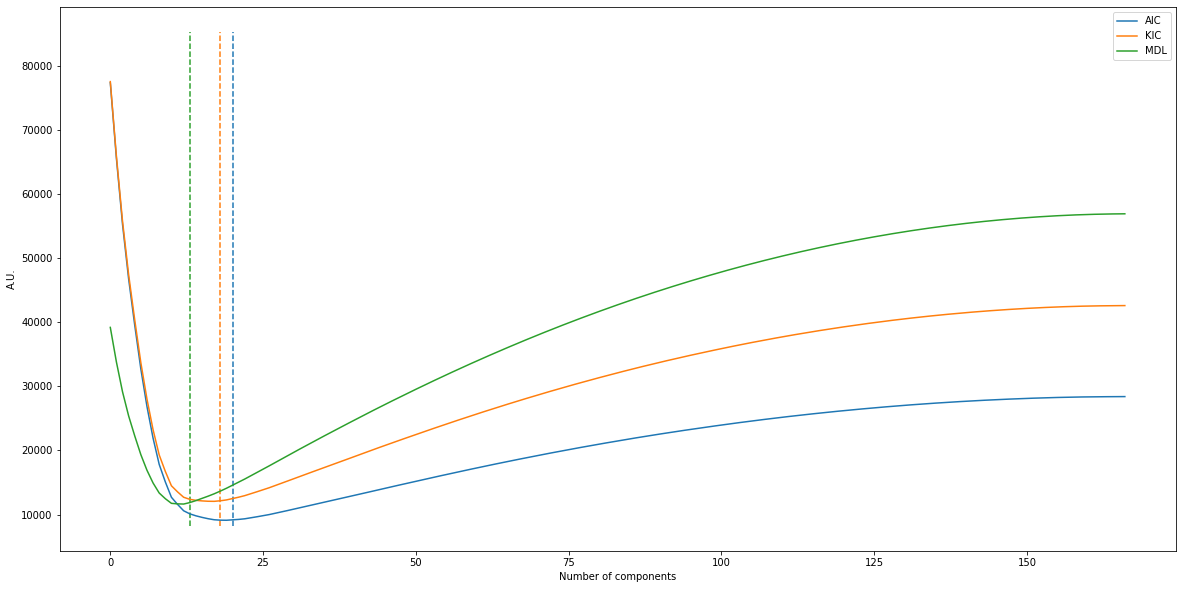

In [91]:
crit, n_crit = estimate_dimensionality(n_timepoints, eigenvalues, N)

plt.figure(figsize=(20,10))
# Optimization curves
plt.plot(crit[0, :], color="tab:blue", label="AIC")
plt.plot(crit[1, :], color="tab:orange", label="KIC")
plt.plot(crit[2, :], color="tab:green", label="MDL")

# Selected components
plt.vlines(n_crit[0], ymin=np.min(crit)*0.9, ymax=np.max(crit)*1.1, linestyles="dashed", color="tab:blue")
plt.vlines(n_crit[1], ymin=np.min(crit)*0.9, ymax=np.max(crit)*1.1, linestyles="dashed", color="tab:orange")
plt.vlines(n_crit[2], ymin=np.min(crit)*0.9, ymax=np.max(crit)*1.1, linestyles="dashed", color="tab:green")
plt.legend()
plt.xlabel("Number of components")
plt.ylabel("A.U.")

## Step 8: Reduce dimensionality with selected criteria using PCA

In [92]:
# Choose between "aic", "kic" and "mdl"
criterion = "aic"

In [105]:
if criterion == "aic":
    n_components = n_crit[0]
elif criterion == "kic":
    n_components = n_crit[1]
elif criterion == "mdl":
    n_components = n_Crit[2]

    
print(f"Performing PCA with {n_components} components")
ppca = PCA(n_components=n_components, svd_solver="full", copy=False, whiten=False)
ppca.fit(X)
print("Done!")

# Assign attributes from model
components = ppca.components_
explained_variance = ppca.explained_variance_
explained_variance_ratio = ppca.explained_variance_ratio_
singular_values = ppca.singular_values_
mean = ppca.mean_
n_components = ppca.n_components_
n_features = ppca.n_features_
n_samples = ppca.n_samples_
noise_variance = ppca.noise_variance_
component_maps = np.dot(
    np.dot(X, components.T), np.diag(1.0 / explained_variance)
)
component_maps_3d = np.zeros((n_x * n_y * n_z, n_components))
component_maps_3d[mask_vec == 1, :] = component_maps
component_maps_3d = np.reshape(component_maps_3d, (n_x, n_y, n_z, n_components), order="F")
component_maps_nib = nib.Nifti1Image(component_maps_3d, img.affine, img.header)

Performing PCA with 20 components
Done!


## Done!